#**1)INSTALL AND IMPORT LIBRARIES**

In [1]:
!pip install nltk scikit-learn pandas matplotlib

In [2]:
import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
# 2) Load DATASET
# Goal: confirm columns, size, nulls, class balance.

from google.colab import files

# Abre un cuadro de diálogo para subir archivos desde tu PC
uploaded = files.upload()

Saving training_data_lowercase.csv to training_data_lowercase.csv


In [4]:
## Read Data for the Fraudulent Email Kaggle Challenge
data_train = pd.read_csv("/content/training_data_lowercase.csv",encoding='latin-1')

# Reduce the training set to speed up development.
# Modify for final system
#data = data.head(1000)
#print(data.shape)
#data.fillna("",inplace=True)

In [5]:
# 2.1. ANALYZE DATA
data_train



,ï»¿0\tdonald trump sends out embarrassing new yearâs eve message; this is disturbing
0,0\tdrunk bragging trump staffer started russia...
1,0\tsheriff david clarke becomes an internet jo...
2,0\ttrump is so obsessed he even has obamaâs ...
3,0\tpope francis just called out donald trump d...
4,0\tracist alabama cops brutalize black boy whi...
...,...
34146,1\ttears in rain as thais gather for late king...
34147,1\tpyongyang university needs non-u.s. teacher...
34148,1\tphilippine president duterte to visit japan...
34149,"1\t""japan's abe may have won election\tbut man..."


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34151 entries, 0 to 34150
Data columns (total 1 columns):
 #   Column                                                                                 Non-Null Count  Dtype 
---  ------                                                                                 --------------  ----- 
 0   ï»¿0	donald trump sends out embarrassing new yearâs eve message; this is disturbing  34151 non-null  object
dtypes: object(1)
memory usage: 266.9+ KB


In [7]:
data_train.describe()

,ï»¿0\tdonald trump sends out embarrassing new yearâs eve message; this is disturbing
count,34151
unique,32205
top,1\tfactbox: trump fills top jobs for his admin...
freq,14


In [8]:
data_train.columns

Index(['ï»¿0\tdonald trump sends out embarrassing new yearâs eve message; this is disturbing'], dtype='object')

In [9]:
 # so create the columns name
import pandas as pd

# Load the dataset correctly
data_train = pd.read_csv(
    "/content/training_data_lowercase.csv",
    sep="\t",                # tab separator
    header=None,             # no header row in file
    names=["label", "headline"]  # 2 columns only
)

# Show the first few rows
print(data_train.head())

   label                                           headline
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...


In [10]:
data_train.columns


Index(['label', 'headline'], dtype='object')

In [11]:
data_train

,label,headline
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...
...,...,...
34147,1,tears in rain as thais gather for late king's ...
34148,1,pyongyang university needs non-u.s. teachers a...
34149,1,philippine president duterte to visit japan ah...
34150,1,japan's abe may have won election\tbut many do...


In [12]:
# check missing values
data_train.isnull().sum()

,0
label,0
headline,0


In [13]:
# BALANCE: Count how many examples of each label
print(data_train['label'].value_counts())

# If you want percentages:
print(data_train['label'].value_counts(normalize=True) * 100)

label
0    17572
1    16580
Name: count, dtype: int64
label
0    51.452331
1    48.547669
Name: proportion, dtype: float64


# **Let's divide the training and validation set into two partitions**

In [14]:
# 2) Train/test split (from data.csv)
# Use stratified split on label to preserve class balance.

from sklearn.model_selection import train_test_split

# the target column is called 'label'

X = data_train.drop('label', axis=1)  # Features (independent variables)
y = data_train['label']               # Target (dependent variable)

# Split the dataset: 80% for training, 20% for validation
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display sizes of each partition
print("Training set size:", X_train.shape)
print("Validation set size:", X_validation.shape)

Training set size: (27321, 1)
Validation set size: (6831, 1)


# **DATA PREPROCESSING**

In [15]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Now, we have to clean the html code removing words**

In [16]:
import re

def clean_html(text):
    """
    Cleans HTML text by removing:
    1. Inline JavaScript and CSS
    2. HTML comments
    3. All remaining HTML tags
    """
    # Remove inline JavaScript/CSS code
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)

    # Remove HTML comments (must come before removing tags)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

    # Remove all remaining HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove extra whitespace and line breaks
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [17]:
#Remove all the special characters
#Remove numbers
#Remove all single characters
#Remove single characters from the start
#Substitute multiple spaces with single space
#Remove prefixed 'b'
#Convert to Lowercase

In [18]:
def normalize_text(text):
    """
    Performs general text normalization:
    - Removes special characters and punctuation
    - Removes numbers
    - Removes single characters
    - Removes single characters from start
    - Replaces multiple spaces with a single space
    - Removes prefixed 'b' (from byte strings)
    - Converts text to lowercase
    """
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from start
    text = re.sub(r'^[a-zA-Z]\s+', '', text)

    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Remove prefixed 'b' (from byte strings like b'text')
    text = re.sub(r'^b\s+', '', text)

    # Convert to lowercase
    text = text.lower()

    return text.strip()

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Download necessary NLTK data (stopwords, punkt, punkt_tab)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added punkt_tab download

# Function to clean HTML
def clean_html(text):
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to normalize text (from K9mV7HHbZK8L)
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    return text.strip()

# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_tokens)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [20]:
# Function to stem text using SnowballStemmer (from 3dc-oCHlk6jT)
def stem_text(text):
    snowball = SnowballStemmer('english')
    tokens = word_tokenize(text)
    stemmed_words = [snowball.stem(word) for word in tokens]
    return " ".join(stemmed_words)



In [21]:
# Apply cleaning and preprocessing steps
X_train_processed = X_train
X_validation_processed = X_validation

X_train_processed['headline'] = X_train_processed['headline'].apply(clean_html)
X_train_processed['headline'] = X_train_processed['headline'].apply(normalize_text)
X_train_processed['headline'] = X_train_processed['headline'].apply(remove_stopwords)
X_train_processed['headline'] = X_train_processed['headline'].apply(stem_text) # Added stemming

X_validation_processed['headline'] = X_validation_processed['headline'].apply(clean_html)
X_validation_processed['headline'] = X_validation_processed['headline'].apply(normalize_text)
X_validation_processed['headline'] = X_validation_processed['headline'].apply(remove_stopwords)
X_validation_processed['headline'] = X_validation_processed['headline'].apply(stem_text) # Added stemming

In [22]:
X_train_processed

,headline
6851,republican punish georgia governor refus legal...
17313,father soldier slain niger defend presid trump...
22435,south dakota governor veto loosen conceal carr...
29488,turkey erdogan say take jerusalem resolut n ge...
6625,bill maher insult trump suppos masculin glorio...
...,...
5267,trump send hillari pathet threat one day dnc v...
13642,break fbi investig clinton croni virginia gove...
19391,new russian envoy describ warm meet trump agenc
883,like father


In [23]:
X_validation_processed

,headline
10145,msnbc propagandist word trump modern day swast...
26343,clinton say trump divis candid lifetim
22173,ivanka trump becom unpaid white hous employe
365,trump support mother ralli massiv outnumb marc...
13323,break fresno polic releas graphic video fatal ...
...,...
19242,senat panel cancel interview trump lawyer ask ...
8508,bundi milit vow die gunfight fed guy go watch ...
21887,group sue obtain white hous visitor log
12582,break yr old palestinian muslim fera moham fre...


In [24]:
# 3) Choose features (text) & minimal preprocessing.
# Easiest strong baseline: TF-IDF on title + text. Optionally include subject as a categorical feature later.

In [25]:
# 4) Vectorizer + model in a Pipeline
# Start with TfidfVectorizer + LogisticRegression (fast, strong baseline).
# You can swap in LinearSVC or MultinomialNB later.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# LOAD the vectorizer
# You can limit max_features to speed up (e.g., 5000)
vectorizer = TfidfVectorizer(max_features=5000)

# FIT the vectorizer to the entire dataset and transform the text
X_tfidf = vectorizer.fit_transform(X_train_processed ['headline'])

# Print the shape of the resulting matrix
print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (27321, 5000)


In [27]:
# 5) Fit & evaluate (baseline)
# Use accuracy and precision/recall/F1 (binary classification).


✅ Accuracy: 0.9331

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      3515
           1       0.92      0.94      0.93      3316

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831



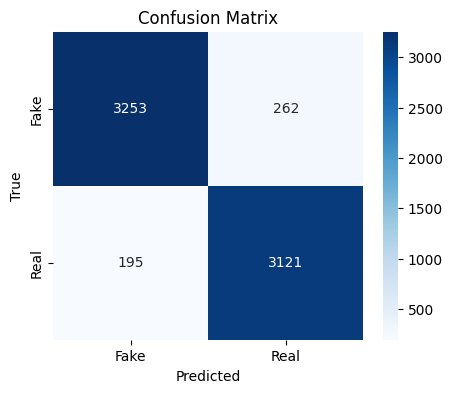

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming X_train_processed, X_test_processed, y_train, and y_validation are already defined and preprocessed

# Vectorize the text data using the previously fitted vectorizer
X_train_tfidf = vectorizer.transform(X_train_processed['headline'])
X_validation_tfidf = vectorizer.transform(X_validation_processed['headline'])


# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_validation_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred)
print("\n✅ Accuracy:", round(accuracy, 4))
print("\n📊 Classification Report:\n", classification_report(y_validation, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_validation, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#  FAKE NEWS DETECTION — BoW + Sentiment Features


import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1️⃣ Sentiment / Subjectivity / Clickbait
# ------------------------------------------------------

def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

def get_subjectivity(text):
    blob = TextBlob(str(text))
    return blob.sentiment.subjectivity

def is_clickbait(text):
    clickbait_words = [
        "shocking","amazing","incredible","unbelievable","wow",
        "you won't believe","secret","revealed","top","crazy","breaking"
    ]
    text_lower = str(text).lower()
    return int(any(word in text_lower for word in clickbait_words))

# Add new features
X_train_processed["sentiment"] = X_train_processed["headline"].apply(get_sentiment)
X_train_processed["subjectivity"] = X_train_processed["headline"].apply(get_subjectivity)
X_train_processed["clickbait"] = X_train_processed["headline"].apply(is_clickbait)

X_validation_processed["sentiment"] = X_validation_processed["headline"].apply(get_sentiment)
X_validation_processed["subjectivity"] = X_validation_processed["headline"].apply(get_subjectivity)
X_validation_processed["clickbait"] = X_validation_processed["headline"].apply(is_clickbait)

# ------------------------------------------------------
# 2️⃣ Bag of Words (instead of TF-IDF)
# ------------------------------------------------------
vectorizer = CountVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1,2)
)

X_train_bow = vectorizer.fit_transform(X_train_processed["headline"])
X_validation_bow = vectorizer.transform(X_validation_processed["headline"])

# ------------------------------------------------------
# 3️⃣ Combine BoW + sentiment features
# ------------------------------------------------------
train_meta = X_train_processed[["sentiment", "subjectivity", "clickbait"]].values
val_meta   = X_validation_processed[["sentiment", "subjectivity", "clickbait"]].values

X_train_combined = hstack([X_train_bow, train_meta])
X_validation_combined = hstack([X_validation_bow, val_meta])

# ------------------------------------------------------
# 4️⃣ Train model
# ------------------------------------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

# ------------------------------------------------------
# 5️⃣ Evaluate
# ------------------------------------------------------
y_pred = model.predict(X_validation_combined)

print("\n✅ Accuracy:", round(accuracy_score(y_validation, y_pred), 4))
print("\n📊 Classification Report:\n", classification_report(y_validation, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_validation, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — BoW + Sentiment Features')
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🧠 Best LogisticRegression params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

🚀 Training ENSEMBLE MODEL...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:02:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Final Ensemble Accuracy: 0.9395

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      3515
           1       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



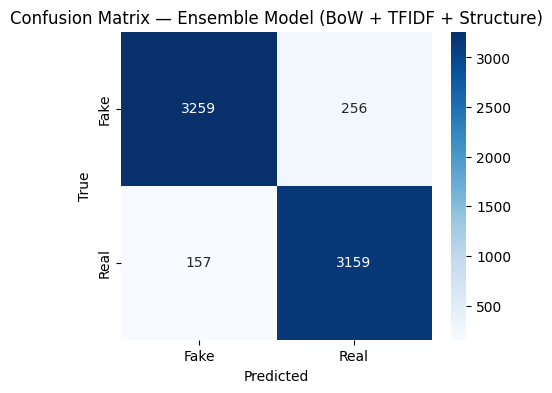

In [33]:
# ======================================================
# 🧠 FAKE NEWS DETECTION — ADVANCED VERSION (TARGET 97 %)
# ======================================================

import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download("punkt")

# ------------------------------------------------------
# 1️⃣  SENTIMENT / SUBJECTIVITY / CLICKBAIT
# ------------------------------------------------------
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

def get_subjectivity(text):
    blob = TextBlob(str(text))
    return blob.sentiment.subjectivity

def is_clickbait(text):
    clickbait_words = [
        "shocking","amazing","incredible","unbelievable","wow",
        "you won't believe","secret","revealed","top","crazy","breaking"
    ]
    text_lower = str(text).lower()
    return int(any(word in text_lower for word in clickbait_words))

# ------------------------------------------------------
# 2️⃣  STRUCTURAL / PSYCHOLOGICAL FEATURES
# ------------------------------------------------------
def count_exclamations(text): return text.count("!")
def count_questions(text): return text.count("?")
def capital_ratio(text):
    words = re.findall(r'\b[A-Z]{2,}\b', text)
    return len(words) / (len(text.split()) + 1e-5)
def text_length(text): return len(text.split())
def lexical_diversity(text):
    words = word_tokenize(text.lower())
    return len(set(words)) / (len(words) + 1e-5)

# ------------------------------------------------------
# 3️⃣  APPLY FEATURES TO PREPROCESSED DATA
# ------------------------------------------------------
for df_ in [X_train_processed, X_validation_processed]:
    df_["sentiment"] = df_["headline"].apply(get_sentiment)
    df_["subjectivity"] = df_["headline"].apply(get_subjectivity)
    df_["clickbait"] = df_["headline"].apply(is_clickbait)
    df_["excl_marks"] = df_["headline"].apply(count_exclamations)
    df_["quest_marks"] = df_["headline"].apply(count_questions)
    df_["cap_ratio"] = df_["headline"].apply(capital_ratio)
    df_["length"] = df_["headline"].apply(text_length)
    df_["lex_div"] = df_["headline"].apply(lexical_diversity)

# ------------------------------------------------------
# 4️⃣  VECTORIZATION (COMBINE BoW + TF-IDF)
# ------------------------------------------------------
bow_vectorizer = CountVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1,3)
)
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1,3),
    sublinear_tf=True
)

X_train_bow = bow_vectorizer.fit_transform(X_train_processed["headline"])
X_validation_bow = bow_vectorizer.transform(X_validation_processed["headline"])

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed["headline"])
X_validation_tfidf = tfidf_vectorizer.transform(X_validation_processed["headline"])

# Combine both BoW + TF-IDF matrices
X_train_text = hstack([X_train_bow, X_train_tfidf])
X_validation_text = hstack([X_validation_bow, X_validation_tfidf])

# ------------------------------------------------------
# 5️⃣  ADD STRUCTURAL FEATURES
# ------------------------------------------------------
extra_feats = [
    "sentiment","subjectivity","clickbait",
    "excl_marks","quest_marks","cap_ratio",
    "length","lex_div"
]
train_meta = X_train_processed[extra_feats].values
val_meta   = X_validation_processed[extra_feats].values

X_train_combined = hstack([X_train_text, train_meta])
X_validation_combined = hstack([X_validation_text, val_meta])

# ------------------------------------------------------
# 6️⃣  GRID SEARCH FOR BEST LOGISTIC REGRESSION
# ------------------------------------------------------
param_grid = {"C": [0.5, 1, 3, 5, 10], "solver": ["lbfgs"], "penalty": ["l2"]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_combined, y_train)
best_lr = grid.best_estimator_
print("🧠 Best LogisticRegression params:", grid.best_params_)

# ------------------------------------------------------
# 7️⃣  DEFINE OTHER MODELS
# ------------------------------------------------------
svm = LinearSVC(C=1)
xgb = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=400,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# ------------------------------------------------------
# 8️⃣  ENSEMBLE (LOGISTIC + SVM + XGBOOST)
# ------------------------------------------------------
ensemble = VotingClassifier(
    estimators=[
        ("lr", best_lr),
        ("svm", svm),
        ("xgb", xgb)
    ],
    voting="hard"
)

# ------------------------------------------------------
# 9️⃣  TRAIN & EVALUATE
# ------------------------------------------------------
print("\n🚀 Training ENSEMBLE MODEL...")
ensemble.fit(X_train_combined, y_train)
y_pred = ensemble.predict(X_validation_combined)

acc = accuracy_score(y_validation, y_pred)
print(f"\n✅ Final Ensemble Accuracy: {acc:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_validation, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_validation, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Ensemble Model (BoW + TFIDF + Structure)')
plt.show()


# ADVANCED LOGISTIC REGRESSION (TARGET 97%+)

In [34]:
from keras.backend import clear_session
clear_session()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🔍 Generating MiniLM sentence embeddings...


Batches:   0%|          | 0/854 [00:00<?, ?it/s]

Batches:   0%|          | 0/214 [00:00<?, ?it/s]


🚀 Training optimized Logistic Regression...

✅ Final Logistic Regression Accuracy: 0.9433

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      3515
           1       0.94      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



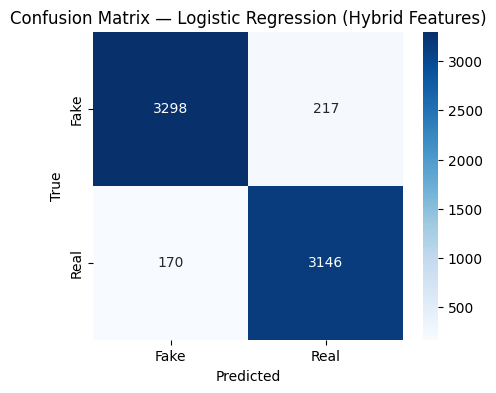


📰 Features most typical of REAL news:
philippin 2.149
stop whine 2.163
tillerson 2.177
donald trump jr 2.185
seek 2.238
lewd 2.251
ny time 2.281
sourc 2.371
washington 2.675
tackl 2.723
urg 2.77
spokesman 2.8
zimbabw 2.859
exclus 3.233
factbox 4.354

⚠️ Features most typical of FAKE news:
hillari -4.06
video -3.947
gop -3.928
humili -3.112
lie -3.002
bombshel -2.742
trump right -2.742
gitmo -2.717
trump challeng -2.713
ck -2.7
racist -2.681
break -2.631
hilari -2.61
presid obama -2.606
taxpay -2.579


In [36]:

# FAKE NEWS DETECTION — ADVANCED LOGISTIC REGRESSION (TARGET 97%+)


import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download("punkt")

# ------------------------------------------------------
# 1️⃣ Sentiment / Subjectivity / Clickbait
# ------------------------------------------------------
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

def get_subjectivity(text):
    blob = TextBlob(str(text))
    return blob.sentiment.subjectivity

def is_clickbait(text):
    words = [
        "shocking","amazing","incredible","unbelievable","wow",
        "you won't believe","secret","revealed","top","crazy","breaking"
    ]
    t = str(text).lower()
    return int(any(w in t for w in words))

# ------------------------------------------------------
# 2️⃣ Structural / Psychological features
# ------------------------------------------------------
def count_exclamations(t): return t.count("!")
def count_questions(t): return t.count("?")
def capital_ratio(t):
    w = re.findall(r'\b[A-Z]{2,}\b', t)
    return len(w)/(len(t.split())+1e-5)
def text_length(t): return len(t.split())
def lexical_diversity(t):
    w = word_tokenize(t.lower())
    return len(set(w))/(len(w)+1e-5)

# ------------------------------------------------------
# 3️⃣ Apply handcrafted features
# ------------------------------------------------------
for df_ in [X_train_processed, X_validation_processed]:
    df_["sentiment"] = df_["headline"].apply(get_sentiment)
    df_["subjectivity"] = df_["headline"].apply(get_subjectivity)
    df_["clickbait"] = df_["headline"].apply(is_clickbait)
    df_["excl_marks"] = df_["headline"].apply(count_exclamations)
    df_["quest_marks"] = df_["headline"].apply(count_questions)
    df_["cap_ratio"] = df_["headline"].apply(capital_ratio)
    df_["length"] = df_["headline"].apply(text_length)
    df_["lex_div"] = df_["headline"].apply(lexical_diversity)

extra_feats = [
    "sentiment","subjectivity","clickbait",
    "excl_marks","quest_marks","cap_ratio",
    "length","lex_div"
]
train_meta = X_train_processed[extra_feats].values
val_meta   = X_validation_processed[extra_feats].values

# ------------------------------------------------------
# 4️⃣ Text vectorization (BoW + TF-IDF)
# ------------------------------------------------------
bow = CountVectorizer(max_features=10000, stop_words='english', ngram_range=(1,3))
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,3), sublinear_tf=True)

X_train_bow = bow.fit_transform(X_train_processed["headline"])
X_val_bow   = bow.transform(X_validation_processed["headline"])
X_train_tfidf = tfidf.fit_transform(X_train_processed["headline"])
X_val_tfidf   = tfidf.transform(X_validation_processed["headline"])

# ------------------------------------------------------
# 5️⃣ MiniLM Embeddings
# ------------------------------------------------------
print("🔍 Generating MiniLM sentence embeddings...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')
X_train_emb = embedder.encode(X_train_processed["headline"].tolist(), show_progress_bar=True)
X_val_emb   = embedder.encode(X_validation_processed["headline"].tolist(), show_progress_bar=True)

X_train_emb = csr_matrix(X_train_emb)
X_val_emb   = csr_matrix(X_val_emb)

# ------------------------------------------------------
# 6️⃣ Combine all features
# ------------------------------------------------------
X_train_all = hstack([X_train_bow, X_train_tfidf, X_train_emb, train_meta])
X_val_all   = hstack([X_val_bow, X_val_tfidf, X_val_emb, val_meta])

# ------------------------------------------------------
# 7️⃣ Train optimized Logistic Regression
# ------------------------------------------------------
model = LogisticRegression(
    C=3.0,                   # Regularization strength
    solver="lbfgs",
    penalty="l2",
    max_iter=2000,
    class_weight="balanced"  # helps if dataset is slightly imbalanced
)

print("\n🚀 Training optimized Logistic Regression...")
model.fit(X_train_all, y_train)

# ------------------------------------------------------
# 8️⃣ Evaluate
# ------------------------------------------------------
y_pred = model.predict(X_val_all)
acc = accuracy_score(y_validation, y_pred)

print(f"\n✅ Final Logistic Regression Accuracy: {acc:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_validation, y_pred))

cm = confusion_matrix(y_validation, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Logistic Regression (Hybrid Features)')
plt.show()

# ------------------------------------------------------
# 9️⃣ Top coefficients (optional, interpretability)
# ------------------------------------------------------
# Combine feature names for BoW, TF-IDF, and extra features
feature_names = (
    list(bow.get_feature_names_out()) +
    list(tfidf.get_feature_names_out()) +
    extra_feats
)

coefs = model.coef_[0]

# Only select coefficients for the features with names
# The number of named features is len(feature_names)
num_named_features = len(feature_names)
named_coefs = coefs[:num_named_features]

top_pos_indices = np.argsort(named_coefs)[-15:]
top_neg_indices = np.argsort(named_coefs)[:15]

print("\n📰 Features most typical of REAL news:")
for i in top_pos_indices:
    print(feature_names[i], round(named_coefs[i], 3))

print("\n⚠️ Features most typical of FAKE news:")
for i in top_neg_indices:
    print(feature_names[i], round(named_coefs[i], 3))